# Unsupervised Classfication

In [1]:
# PARAMS
lang = 'fr'

%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False

In [2]:
!pip install gensim
!pip install nltk
!pip install scikit-learn

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
# Imports the OS library
import os

# Imports the time library
from time import time

# Imports the document class
from document import Document

# Import TQDM for time measurements
from tqdm import tqdm

# Imports NLTK
import nltk
nltk.download('punkt')
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk.corpus import reuters
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
    
# Imports gensim
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import strip_punctuation

# Imports scikit learn
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Imports matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker

# Imports wordcloud
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.6/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Preprocessing

In [4]:
def preprocess_text(data, language='en'):
    
    # Creates the language dictionary
    lang_dict = {
        "en": "english",
        "es": "spanish",
        "fr": "french"
    }
    
    # Sets text into lowercase
    data = data.lower()
    
    # Removes punctuation
    data = strip_punctuation(data)
    
    # Tokenizes by word
    data = word_tokenize(data)
    
    # Removes stopwords
    data = [token for token in data if token not in stopwords.words(lang_dict[language])]
    
    # Creates the stemmer
    stemmer = SnowballStemmer(lang_dict[language])
    
    # Stems data
    data = [ stemmer.stem(token) for token in data]
    
    # Returns preprocessed text
    return data


## Loads News Data

In [5]:
path_to_news = "../../data/news/" + lang + '/'

# Gets the news files
news_list = os.listdir(path_to_news)

# Splits the data into training and validation
X_train, X_test = train_test_split(news_list, train_size=0.2)

# Deletes the original news list
del news_list

## Memory data
This will load data into memory for Doc2Vec training.

In [6]:
train_docs = []

for indx, file in enumerate(tqdm(X_train)):
    
    doc = Document()
    
    doc.load_from_json(path_to_news + file)
    
    tag = [str(indx)]
    tag.append(doc.keyword)
    
    doc_words = preprocess_text(doc.text, lang)
    
    train_docs.append(TaggedDocument(words=doc_words, tags=tag))

100%|██████████| 44978/44978 [1:29:20<00:00,  8.39it/s]  


### Disk Iterator
This will create an iterator for a memory-friendly data management.

In [7]:
class TaggedNewsIterator:
    
    def __init__(self, filenames, prefix):
        
        self.filenames = filenames
        
        self.files_len = len(filenames)
        
        self.prefix = prefix
        
        self.count = 0
    
    
    def __iter__(self):
        
        self.count = 0
        
        return self
    
    
    def __next__(self):
        
        if self.count >= self.files_len:
            raise StopIteration
        
        # Gets the next filename
        fname = self.filenames[self.count]
        
        doc = Document()
    
        doc.load_from_json(self.prefix + fname)
        
        tag_value = [str(self.count)]
        
        tag_value.append(doc.keyword)
        
        doc_words = preprocess_text(doc.text)
        
        self.count += 1
        
        return TaggedDocument(words=doc_words, tags=tag_value)

    
# train_docs = TaggedNewsIterator(X_train, path_to_news)

## Doc2Vec

In [8]:
ALPHA = 0.025
MIN_COUNT = 10
MAX_EPOCHS = 10

model = Doc2Vec(alpha=ALPHA, min_alpha=0.00025, min_count=MIN_COUNT, dm=1)

dtime = time()

model.build_vocab(train_docs)

dtime = time() - dtime

print("Built model vocab. Took {:2.2f}s".format(dtime))

for epoch in range(MAX_EPOCHS):
    
    dtime = time()
    
    model.train(train_docs, total_examples = model.corpus_count, epochs=model.epochs)
        
    # Decrease the learning rate
    model.alpha -= 0.0002
    
    # Fix the learning rate, no decay
    model.min_alpha = model.alpha
    
    dtime = time() - dtime
    
    print("Trained epoch {}. Took {:4.2f}s".format(epoch, dtime), end='\r')
    
    model.save("doc2vec_{}.model".format(lang))

Built model vocab. Took 7.08s


In [9]:
model = Doc2Vec.load("doc2vec_{}.model".format(lang))

## Document Representation

In [10]:
path_to_news = "../../data/news/" + lang + '/'

# Gets the news files
news_list = os.listdir(path_to_news)

# Splits the data into training and validation
X_train, X_test = train_test_split(news_list, train_size=0.85)

# Deletes the original news list
del news_list

In [11]:
train_vectors = []

for file in tqdm(X_train):
    
    doc = Document()
    doc.load_from_json(path_to_news + file)
    
    pre_text = preprocess_text(doc.text, lang)
    
    train_vectors.append(model.infer_vector(pre_text))


100%|██████████| 191159/191159 [6:16:33<00:00,  8.46it/s]   


## Classification Model

In [12]:
k_means = KMeans(n_clusters=16)

In [13]:
k_means.fit(train_vectors)

KMeans(n_clusters=16)

## Model Testing

In [14]:
test_vectors = []
test_categories = []

for file in tqdm(X_test):
    
    doc = Document()
    doc.load_from_json(path_to_news + file)
    
    pre_text = preprocess_text(doc.text, lang)
    
    test_vectors.append(model.infer_vector(pre_text))
    test_categories.append(doc.keyword)


100%|██████████| 33735/33735 [58:04<00:00,  9.68it/s]  


In [15]:
y_pred = k_means.predict(test_vectors)

## Results Generation

In [16]:
le = LabelEncoder()
le.fit(test_categories)
y_true = le.transform(test_categories)

conf_matrix = confusion_matrix(y_true, y_pred)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


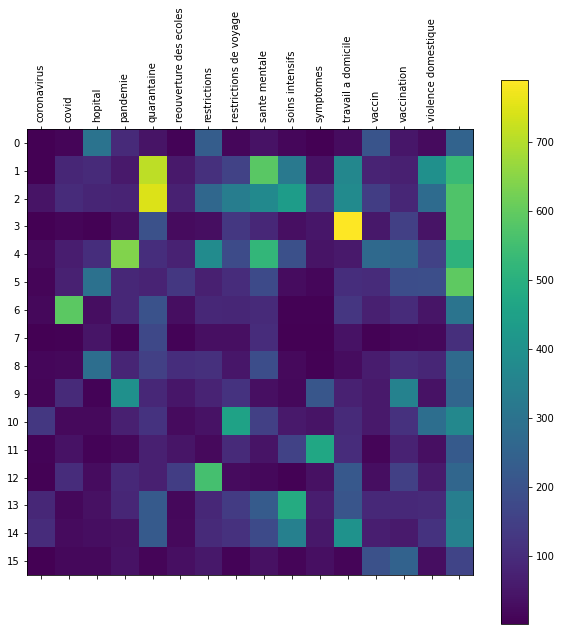

In [17]:
categories = le.inverse_transform([i for i in range(16)])

fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111)
cax = ax.matshow(conf_matrix)
fig.colorbar(cax)
ax.set_xticklabels(categories, rotation=90)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.savefig("../../results/AutomaticIdentification/cf_{}.pdf".format(lang))
plt.show()

In [ ]:
import csv
import numpy as np

fname = "X_train_{}.txt".format(lang)

with open(fname, "w") as x_train_file:
    fwriter = csv.writer(x_train_file, delimiter=',')
    
    for file in X_train:
        fwriter.writerow([file])


fname = "X_test_{}.txt".format(lang)

with open(fname, "w") as x_train_file:
    fwriter = csv.writer(x_train_file, delimiter=',')
    
    for file in X_test:
        fwriter.writerow([file])
        
x_train_embeddings_arr = np.asarray(train_vectors)

np.savetxt("X_train_vectors_{}.csv".format(lang), x_train_embeddings_arr, delimiter=',')

x_test_embeddings_arr = np.asarray(test_vectors)

np.savetxt("X_test_vectors_{}.csv".format(lang), x_test_embeddings_arr, delimiter=',')